## Dimitrios Fikos 9/12/2024
#### Application to a Real dataset. 

The four algorithms for gradient estimation leading to dimension reduction are going to be tested in real circumstances in order to test the prediction ability.
Data were taken by NASA ( https://power.larc.nasa.gov/data-access-viewer/ ) corresponding to some weather data about a specific location for the last 40 years. Details about each variable are given in the excel file. 17 variables were selected, one was decided to be the response variable and the other 16 as input variables. In the end, results show an effective diminish of dimensions of the dataset from $p=16$ to $d=3$.

In [1]:
import math
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


### Data cleaning and analysis

In [3]:
file_path = 'Weather_dataset.xlsx'
# Read the Excel file
df = pd.read_excel(file_path)
df=pd.DataFrame(df)

In [4]:
# Drop the first 25 rows
df = df.iloc[25:].reset_index(drop=True)
# Drop these two columns
df=df.drop(columns=['-BEGIN HEADER-', 'Unnamed: 1'])
# Define the new column names
new_column_names = [
    'T2M', 'T2MDEW', 'TS', 'QV2M', 'RH2M', 'PRECTOTCORR', 
    'PS', 'WS2M', 'WD2M', 'WS10M', 'WD10M', 'GWETTOP', 
    'GWETROOT', 'ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_UVB', 
    'ALLSKY_SFC_UVA', 'ALLSKY_SFC_SW_DWN']
df.columns = new_column_names
# turn the types to float
df = df.apply(pd.to_numeric, errors='coerce')

Number of Rows : 7306
Number of Columns : 17
               T2M       T2MDEW           TS         QV2M         RH2M  \
count  7306.000000  7306.000000  7306.000000  7306.000000  7306.000000   
mean     11.740769     8.486481    11.786660     7.214368    82.488535   
std       5.832932     4.824882     6.142057     2.235873     9.256374   
min      -4.670000    -9.940000    -5.170000     1.710000    34.000000   
25%       7.562500     5.330000     7.360000     5.550000    76.310000   
50%      11.770000     8.880000    11.735000     7.080000    83.120000   
75%      16.300000    12.150000    16.630000     8.790000    89.940000   
max      30.230000    21.810000    30.540000    16.360000    99.750000   

       PRECTOTCORR           PS         WS2M         WD2M        WS10M  \
count  7306.000000  7306.000000  7306.000000  7306.000000  7306.000000   
mean      1.982570   100.828062     2.980646   189.708815     4.519242   
std       3.419322     0.917754     1.284734    84.311314     1.84

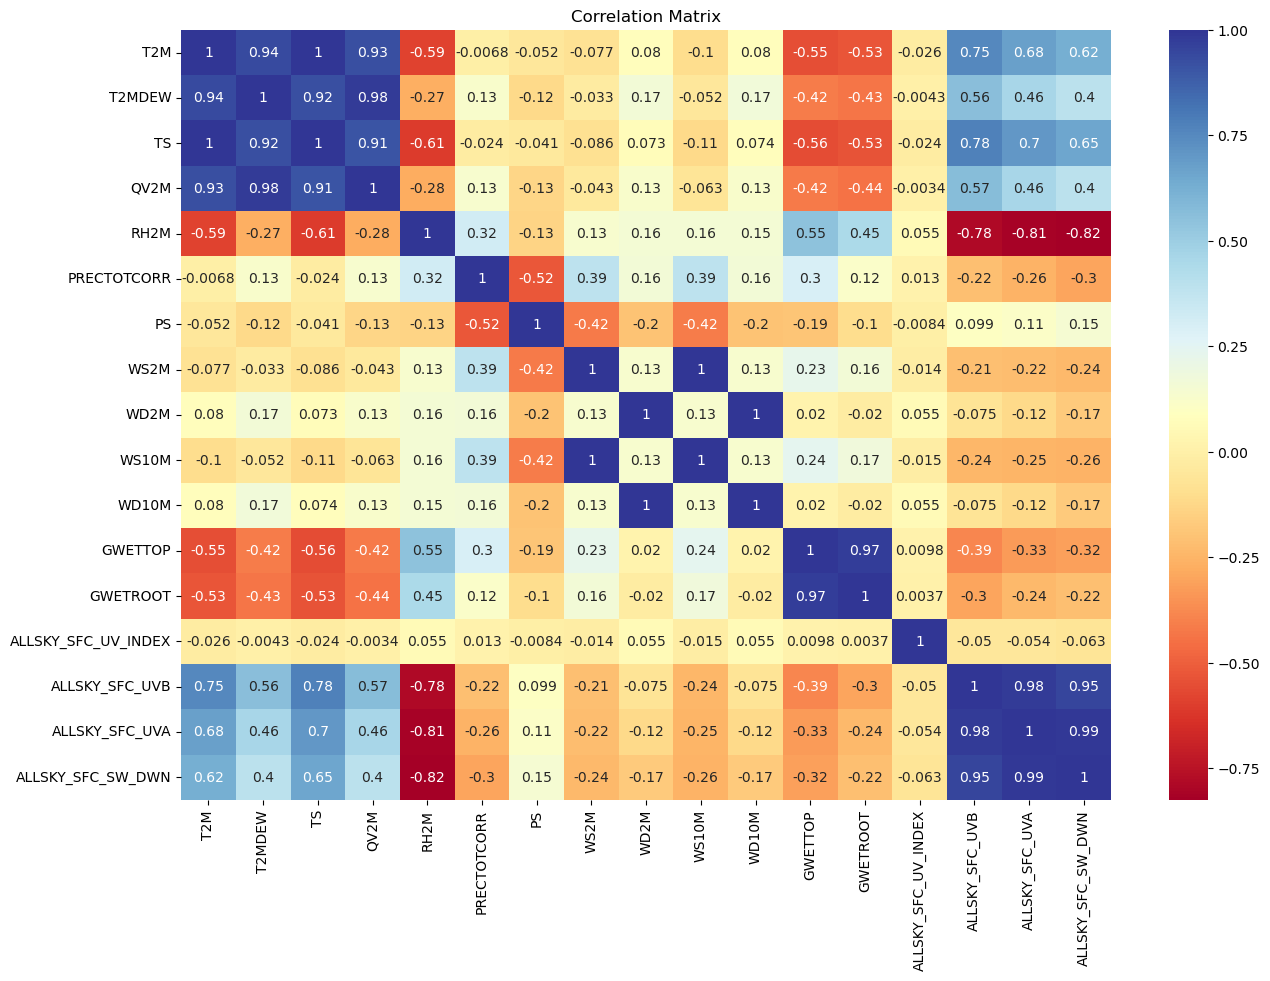

In [5]:
# check for missing data
missing = df.isnull().sum().sort_values(ascending = False)
#print('are there any missing data?\n', missing)
# Number of columns and rows 
print("Number of Rows :" , df.shape[0])
print("Number of Columns :" , df.shape[1])
# Basic Stats
print(df.describe())
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, annot = True, cmap = 'RdYlBu')
plt.title('Correlation Matrix')
plt.show()

## Response Variable selection

From the dataset the 'Temperature at 2 meters' (T2M) variable is going to be predicted by 16 input weather variables.

In [7]:
Y=df[['T2M']].to_numpy()
#print(Y)
X=df.drop(columns=['T2M']).to_numpy()
#print(X)
Y = Y.reshape(-1)
# split training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Algorithms for Gradient estimation leading to Dimension reduction

In [8]:
####### 1) Projection from OLS ########
def b_ols(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        sum_xi = sum_yi =0 
        for i in range(len(nearest_X)):
            sum_xi+=nearest_X[i]
            sum_yi+=nearest_Y[i]
        sum_xi, sum_yi = sum_xi/k, sum_yi/k 
        nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
        # Initialize the Linear Regression model
        linear_regression = LinearRegression(fit_intercept=False)
        # Fit the model to the data
        linear_regression.fit(nearest_X, nearest_Y)
        # Print the coefficient(s)
        estimated_gradient = linear_regression.coef_
        estimations.append(estimated_gradient)
    estimations=np.array(estimations).T
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    return  U, S, Vh

############ 2) b_ols lasso ############
def b_ols_lasso(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        sum_xi = sum_yi =0 
        for i in range(len(nearest_X)):
            sum_xi+=nearest_X[i]
            sum_yi+=nearest_Y[i]
        sum_xi, sum_yi = sum_xi/k, sum_yi/k 
        nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
        # Initialize the Linear Regression model with lasso
        lasso_model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000, tol=1e-4)
        lasso_model.fit(nearest_X, nearest_Y)
        # Print the coefficients
        estimated_gradient = lasso_model.coef_
        estimations.append(estimated_gradient)
    estimations=np.array(estimations).T
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    return U, S, Vh

########### 3) b_ols_diag ###########
def b_ols_diag(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        b_ols=[]
        for j in range(nearest_X.shape[1]):
            numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] 
            denom=np.cov(nearest_X[:, j],nearest_X[:, j])[0,0]
            b_ols.append(numer/denom)
        estimations.append(b_ols)
    estimations=np.array(estimations).T
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)       
    return U, S, Vh

########### 4) b_ols_trace ###########
def b_ols_trace(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        b_ols=[]
        denom=0
        for j in range(nearest_X.shape[1]):
            numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] 
            b_ols.append(numer)
        estimations.append(b_ols)
    estimations=np.array(estimations).T
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)       
    return  U, S, Vh 

In [9]:
# take a random sample of 200 points from the dataset which will be used for gradient estimation per point 
np.random.seed(12) 
random_indices = np.random.choice(X_train.shape[0], size=200, replace=False)
X_specific_train = X_train[random_indices]

## Take the Scree plots

### b_ols

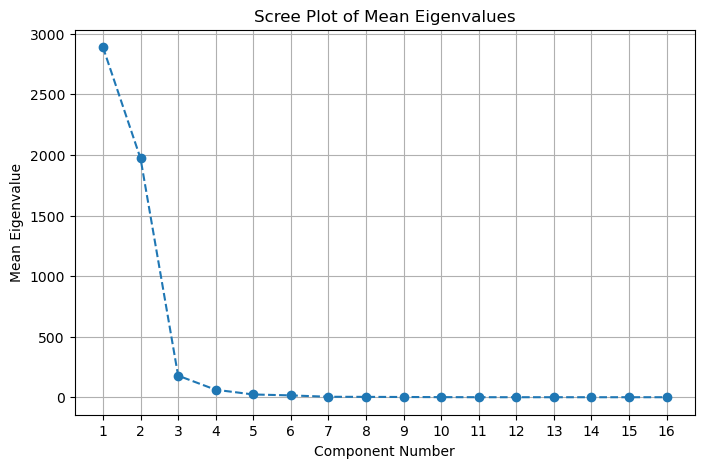

In [10]:
U, S, Vh = b_ols(X_specific_train, X_train, Y_train, k=71, dim=16)
# Convert singular values to eigenvalues by squaring them
eigenvalues_ols = S**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues_ols) + 1), eigenvalues_ols, marker='o', linestyle='--')
plt.title('Scree Plot of Mean Eigenvalues')
plt.xlabel('Component Number')
plt.ylabel('Mean Eigenvalue')
plt.xticks(range(1, len(eigenvalues_ols) + 1))
plt.grid()
plt.show()

### b_ols_lasso

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09991660877259875, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1090584287833809, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11397993653156849, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: Con

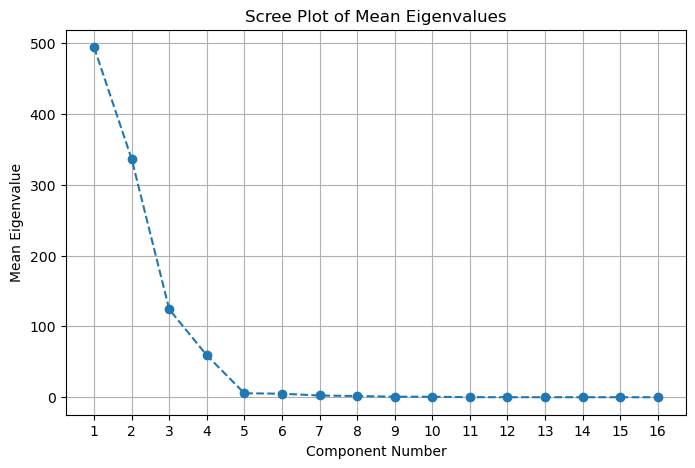

In [11]:
alphas = np.logspace(-6, 0, 20)
U, S, Vh = b_ols_lasso(X_specific_train, X_train, Y_train, k=71, dim=16)  # Get singular values for this dataset
# Convert singular values to eigenvalues by squaring them
eigenvalues_ols_lasso = S**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues_ols_lasso) + 1), eigenvalues_ols_lasso, marker='o', linestyle='--')
plt.title('Scree Plot of Mean Eigenvalues')
plt.xlabel('Component Number')
plt.ylabel('Mean Eigenvalue')
plt.xticks(range(1, len(eigenvalues_ols_lasso) + 1))
plt.grid()
plt.show()

### b_ols_diag

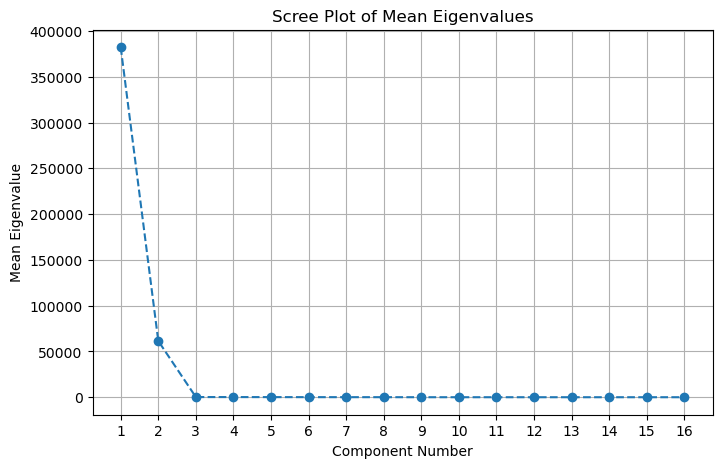

In [12]:
U, S, Vh = b_ols_diag(X_specific_train, X_train, Y_train, k=71, dim=16)  # Get singular values for this dataset
# Convert singular values to eigenvalues by squaring them
eigenvalues_ols_diag = S**2
#print(eigenvalues_ols_diag)
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues_ols_diag) + 1), eigenvalues_ols_diag, marker='o', linestyle='--')
plt.title('Scree Plot of Mean Eigenvalues')
plt.xlabel('Component Number')
plt.ylabel('Mean Eigenvalue')
plt.xticks(range(1, len(eigenvalues_ols_diag) + 1))
plt.grid()
plt.show()

### b_ols_trace

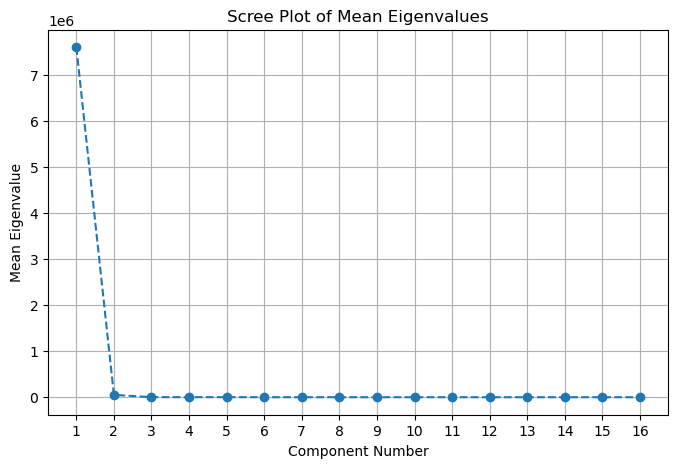

In [13]:
U, S, Vh = b_ols_trace(X_specific_train, X_train, Y_train, k=71, dim=16)  # Get singular values for this dataset
# Convert singular values to eigenvalues by squaring them
eigenvalues_ols_trace = S**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues_ols_trace) + 1), eigenvalues_ols_trace, marker='o', linestyle='--')
plt.title('Scree Plot of Mean Eigenvalues')
plt.xlabel('Component Number')
plt.ylabel('Mean Eigenvalue')
plt.xticks(range(1, len(eigenvalues_ols_trace) + 1))
plt.grid()
plt.show()

### Comments

As explained in script "Principal Components selection" we use scree plots to identify the correct no of components that can be selected for an effective dimension reduction procedure. In this case at the moment plots propose d=3 for OLS, d=4 for OLS-Lasso, d=2 for OLS-diagonal and d=1 for OLS-trace. 

## Compute the new X_train datasets (reduced)

For the continue of the research $d=3$ was selected for comparison of the 4 techniques.

### b_ols

In [14]:
U, S, Vh = b_ols(X_specific_train, X_train, Y_train, k=71, dim=16)  # Get singular values for this dataset
# Number of components 
num_components = 3
# Select the top left singular vectors corresponding to these components
top_ols= U[:,:num_components]
X_train_new_ols = X_train@top_ols

### b_ols_lasso

In [70]:
#alphas = np.logspace(-6, 0, 5)
U, S, Vh = b_ols_lasso(X_specific_train, X_train, Y_train, k=71, dim=16)
# Number of components
num_components = 3
# Select the top left singular vectors corresponding to these components
top_lasso= U[:,:num_components]
X_train_new_lasso = X_train@top_lasso

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09991660877259875, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1090584287833809, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11397993653156849, tolerance: 0.08902082078159096
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: Con

### b_ols_diagonal

In [69]:
U, S, Vh = b_ols_diag(X_specific_train, X_train, Y_train, k=71, dim=16)
# Number of components you want to analyze 
num_components = 3
# Select the top left singular vectors corresponding to these components
top_diag= U[:,:num_components]
X_train_new_diag = X_train@top_diag

### b_ols_trace

In [54]:
U, S, Vh = b_ols_trace(X_specific_train, X_train, Y_train, k=71, dim=16)
# Number of components you want to analyze 
num_components = 3
# Select the top left singular vectors corresponding to these components
top_trace= U[:,:num_components]
X_train_new_trace = X_train@top_trace

## Compute the new X_test datasets (reduced)

In [71]:
# b_ols
X_test_new_ols = X_test@top_ols
# b_ols_lasso
X_test_new_lasso = X_test@top_lasso
# b_ols_diagonal
X_test_new_diag = X_test@top_diag
# b_ols_trace
X_test_new_trace = X_test@top_trace

## Apply KNN Regressor

### Full dataset

In [20]:
# Train KNN 
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', metric='euclidean')
knn.fit(X_train, Y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)
# Evaluation
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
r2 = r2_score(Y_test, y_pred)
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 2.1988
R^2 Score: 0.9348


## b_ols

In [74]:
# Train KNN
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', metric='euclidean')
knn.fit(X_train_new_ols, Y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test_new_ols)
# Evaluation
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.1469
R^2 Score: 0.9956


## b_ols_lasso

In [72]:
# Train KNN 
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', metric='euclidean')
knn.fit(X_train_new_lasso, Y_train)
# Make predictions on the test set
Y_pred = knn.predict(X_test_new_lasso)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.1516
R^2 Score: 0.9955


### b_ols_diagonal

In [73]:
# Train KNN 
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', metric='euclidean')
knn.fit(X_train_new_diag, Y_train)
# Make predictions on the test set
Y_pred = knn.predict(X_test_new_diag)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 1.4532
R^2 Score: 0.9569


### b_ols_trace

In [75]:
# Train KNN 
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', metric='euclidean')
knn.fit(X_train_new_trace, Y_train)
# Make predictions on the test set
Y_pred = knn.predict(X_test_new_trace)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.4625
R^2 Score: 0.9863


### Comments

When applying the KNN Regressor to the full dataset ($d=16$) and to the dimension reduced datasets ($d=3$ was selected for all 4 algorithms) it is clear that we managed to reduce the MSE and increase $R^2$ corrsponding to the explained variablity of the dataset. The prediction of the Temperature at 2M response variable became more accurate. 

## Apply Random Forest

### Full dataset

In [25]:
# Train RandomForest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, Y_train)
# Make predictions on the test set
Y_pred = rf_regressor.predict(X_test)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.0849
R^2 Score: 0.9975


### b_ols

In [76]:
# Train RandomForest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_new_ols, Y_train)
# Make predictions on the test set
Y_pred = rf_regressor.predict(X_test_new_ols)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.0679
R^2 Score: 0.9980


### b_ols_lasso

In [77]:
# Train RandomForest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_new_lasso, Y_train)
# Make predictions on the test set
Y_pred = rf_regressor.predict(X_test_new_lasso)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.0673
R^2 Score: 0.9980


### b_ols_diag

In [78]:
# Train RandomForest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_new_diag, Y_train)
# Make predictions on the test set
Y_pred = rf_regressor.predict(X_test_new_diag)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 1.1140
R^2 Score: 0.9669


### b_ols_trace

In [79]:
# Train RandomForest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_new_trace, Y_train)
# Make predictions on the test set
Y_pred = rf_regressor.predict(X_test_new_trace)
# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.2765
R^2 Score: 0.9918


### Comments

When applying the Random Forest Regressor to the full dataset ($d=16$) and to the dimension reduced datasets ($d=3$ was selected for all 4 algorithms) it is clear that we managed to reduce the MSE and increase $R^2$ to OLS and OLS Lasso. In OLS-diagonal and OLS-trace the prediction of the Temperature at 2M response variable became slighthly less accurate. 